In [103]:
from collections import defaultdict
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import re
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import spacy
from typing import Callable, Dict, List, Optional, Set, Tuple

Possible interesting questions:
<ul>
    <li> <s>Who was the most influential TA?</s>
    <li> <s>What types of messages did the most influential TA send (i.e. what types of help did they give to students)?</s>
    <li> <s>What types of questions did students tend to ask?</s>
    <li> <s>What types of questions did students tend to ask, broken down by channel (could also just look at channels regarding projects and homework, instead of every channel)</s>
    <li> How much did questions change over time, in the order of the projects
    <ul>
        <li> Can look at quantity of messages, by project
        <li> Can look at types of messages, by project
    </ul>
    <li> <s>Which students needed the most help (asked the most questions)?</s>
    <li> <s>Which students (not TAs or instructor) answered the most questions (could be useful to identify future TA hiring opportunities)?</s>
    <li> What communities do GCNs and/or Node2Vec discover?
    <li> Are there communities of students that have little to no TA interaction?
    <li> Are there more TA-student relationships or student-student relationships?
    <li> How often are code snippets posted?
    <li> What type of structure do student nodes form (core-periphery or homophily)?
    <li> How does community structure differ when TAs are in the network vs. not in the network?
    <li> How often do threads occur?
    <li> Collect a lot of metrics and compare them to small-world, scale-free, mixing matrix, etc.
</ul>

For all of these, run them on the 324 graph and compare

### Helper Code

In [2]:
def get_arg_max_real(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if np.real(x[i])> M:
            M = np.real(x[i])
            index=i
    return index

def get_arg_max_modulus(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if x[i]>= M:
            M = x[i]
            index=i
    return index

def get_leading_eigenvector(B):
    [vals,vecs] = np.linalg.eig(B)
    # If no positive eigenvalues, to within round off error
    if all(v < 1e-4 for v in list(vals)): 
        ones = np.ones((1,len(B))) / np.sqrt(len(B)) # Normalized vector of all 1's
        max_vec = ones[0,:]
    else:
        arg_max = get_arg_max_real(vals)
        max_vec = np.real(vecs[:,arg_max])
    return max_vec

def get_principal_eigenvector(A):
    [vals,vecs] = np.linalg.eig(A)
    arg_max = get_arg_max_modulus(vals)
    max_vec = vecs[:,arg_max]
    return max_vec

def get_shores_from_eigenvector(nodes,x):
    shore1 = set()
    shore2 = set()
    for node in nodes:
        if x[node] < 0: shore1.add(node)
        else: shore2.add(node)
    return [shore1, shore2]

def get_two_fiedler_eigenvectors(L):
    [evals, evecs] = np.linalg.eig(L)
    sorted_indices = np.argsort(evals)
    two_smallest_nonzero = []
    for i in sorted_indices:
        if evals[i] ==0: continue
        two_smallest_nonzero.append(i)
        if len(two_smallest_nonzero) == 2: break
    print(two_smallest_nonzero)
    fiedler1 = evecs[:,two_smallest_nonzero[0]]
    fiedler2 = evecs[:,two_smallest_nonzero[1]]
    return fiedler1, fiedler2

def get_largest_vectors(A):
    [evals, evecs] = np.linalg.eig(A)
    evals = [0 if np.abs(v) < 1e-5 else np.round(np.abs(v),1) for v in evals]
    sorted_indices = np.argsort(evals)
    two_largest_nonzero = []
    for i in np.flip(sorted_indices):
        two_largest_nonzero.append(i)
        if len(two_largest_nonzero) == 2: break
    big1 = np.real(evecs[:,two_largest_nonzero[0]])
    big2 = np.real(evecs[:,two_largest_nonzero[1]])
    return big1, big2

def form_encoding(vector1, vector2):
    z = np.zeros((len(vector1),2))
    for i in range(len(vector1)):
        z[i,0] = vector1[i]
        z[i,1] = vector2[i]
    return z

def get_clusters(embedding, num_clusters=4):
    kmeans = KMeans(
        init="random",
        n_clusters=num_clusters,
        n_init=10,
        random_state=1234
        )
    kmeans.fit(embedding)
    return kmeans

def get_colors_from_clusters(embedding, num_clusters = 4):
    kmeans = get_clusters(embedding, num_clusters=num_clusters)
    labels = kmeans.labels_
    color_template = ['y', 'c', 'm', 'k', 'red', 'green', 'lightblue']
    color = [color_template[x] for x in list(labels) ]
    return color

In [3]:
class graphHandler:
    def __init__(self, G, colormap, use_pydot = True):
        # self.G = nx.convert_node_labels_to_integers(G)
        self.G = G
        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None, with_labels = False, legend = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        if with_labels:
            nx.draw(self.G,self.pos,node_color = agent_colors, with_labels = with_labels, node_size = 200, alpha=0.8)
        else:
            nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        if legend is not None:
            plt.legend(handles = legend, loc = 'best')
        plt.show()
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan', 'red']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            color = colors[kcore%len(colors)]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=color)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')

    def show_kCores_by_partition(self, colors, title = "K-core of Network"):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # Shapes
        shapes = ["o", "v", "s", "*", "+", "d"]

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(kcores.keys(),reverse=True):
            nodes = kcores[kcore]
            shape = shapes[kcore%len(shapes)]
            
            #nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[nodes[0]], node_shape=shape, alpha = 0.5, node_size=90)
            for node in nodes:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[node], node_shape=shape, alpha = 0.5, node_size=90)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker=shape, color='k', markerfacecolor = 'w', label=label, markersize=10))
        
        nx.draw_networkx_edges(self.G, pos, width=0.1)
        #nx.draw_networkx_labels(self.G, pos)
        plt.title(title)
        plt.legend(handles = legend_elements, loc = 'best')

    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            print(f"Partition {partition_number} is {partition}")
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

In [4]:
def read_data(folder_path: str = './final_project_files') -> Tuple[pd.DataFrame, pd.DataFrame]:
    nodes_file = f'{folder_path}/nodes.csv'
    edges_file =  f'{folder_path}/edges.csv'
    nodes_data = pd.read_csv(nodes_file)
    edges_data = pd.read_csv(edges_file)
    
    return nodes_data, edges_data

In [5]:
def create_graph(nodes_data: pd.DataFrame, edges_data: pd.DataFrame, show_graph: bool = False) -> graphHandler:
    # Use nodes and edges to create the graph
    G = nx.Graph()

    for i in nodes_data.index:
        source = edges_data['source'][i]
        target = edges_data['target'][i]

        if source != target: # Don't include self loops
            G.add_edge(source, target)

    # Add node types and values
    node_type_dict = {nodes_data['node'][i]: nodes_data['type'][i] for i in nodes_data.index}
    node_value_dict = {nodes_data['node'][i]: nodes_data['value'][i] for i in nodes_data.index}
    nx.set_node_attributes(G, node_type_dict, 'node_type')
    nx.set_node_attributes(G, node_value_dict, 'node_value')

    # Add edge types and messages/content
    edge_type_dict = {(edges_data['source'][i], edges_data['target'][i]): edges_data['edge_type'][i] for i in edges_data.index}
    edge_content_dict = {(edges_data['source'][i], edges_data['target'][i]): edges_data['content'][i] for i in edges_data.index}
    nx.set_edge_attributes(G, edge_type_dict, 'edge_type')
    nx.set_edge_attributes(G, edge_content_dict, 'content')

    # Wrap the graph in a graph handler (gives us extra functionality)
    graph_handler = graphHandler(G, ['y' for _ in G.nodes], use_pydot=False)

    if show_graph:
        colors = []
        H = graph_handler.getGraph() # Get graph sorted by value
        color_map = ['y', 'm', 'c', 'b', 'g', 'k']
        types = list(set(node_type_dict.values()))
        type_colors = {types[i]: color_map[i%len(color_map)] for i in range(len(types))}
        legend_elements = []

        for node_type in type_colors.keys():
            legend_elements.append(Line2D([0], [0], marker='o', color=type_colors[node_type], markerfacecolor = type_colors[node_type], label=node_type, markersize=10))

        for node in H.nodes:
            colors.append(type_colors[G.nodes[node]['node_type']])

        graph_handler.showGraph(title='CS 236 Discord Graph', agent_colors=colors, legend=legend_elements)

    return graph_handler

In [6]:
# Projection 1
def remove_nodes(handler: graphHandler, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [7]:
# Projection 1
def remove_nodes_by_value(handler: graphHandler, node_values_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_value'] in node_values_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [8]:
# Projection 2
def remove_edges(handler: graphHandler, edge_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_edges_from([edge for edge in graph_copy.edges if graph_copy.nodes[edge]['edge_type'] in edge_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [9]:
# Projection 3
def remove_singletons(handler: graphHandler) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [10]:
# Projection 4
def add_new_relationship(handler: graphHandler, direct_relationship_edge_type: str, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Create bi-partite graph by removing edges that represent direct relationships
    direct_relationship_edges = []  # We'll need to add these back at the end

    for u, v, attrs in list(graph_copy.edges(data=True)):
        if attrs['edge_type'] == direct_relationship_edge_type:
            graph_copy.remove_edge(u, v)
            direct_relationship_edges.append((u, v, attrs))

    # Calculate the two-step paths matrix
    A = nx.adjacency_matrix(graph_copy).toarray()
    two_step_paths = A @ A

    # Remove self-loops
    np.fill_diagonal(two_step_paths, 0)

    # Add edges between nodes based on the two-step path matrix
    nodes = list(graph_copy.nodes())

    for i in range(len(two_step_paths)):
        for j in range(len(two_step_paths[0])):
            node_1, node_2 = nodes[i], nodes[j]

            if two_step_paths[i][j] > 0:
                graph_copy.add_edge(node_1, node_2)

    # Add back the edges that represent direct relationships
    graph_copy.add_edges_from(direct_relationship_edges)

    # Remove any unwanted nodes and singletons
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])

    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

In [11]:
def who_interacted_with_whom(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))

    return projected_graph_handler

In [12]:
def who_interacted_with_whom_just_students(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel'
    projected_graph_handler = remove_nodes_by_value(projected_graph_handler, set(['TA', 'Instructor']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        if attrs['node_type'] == 'person':
            assert attrs['node_value'] == 'Student'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))

    return projected_graph_handler

In [13]:
def show_eigenvector_communities(handler: graphHandler) -> None:
    graph = handler.getGraph()
    A = nx.adjacency_matrix(graph).toarray()
    v1, v2 = get_largest_vectors(A)
    embedding = form_encoding(v1, v2)
    colors = get_colors_from_clusters(embedding, num_clusters=3)
    plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors)
    plt.title('Eigenvector Embeddings')
    plt.show()
    handler.showGraph(title='Eigenvector Communities', agent_colors=colors, with_labels=True)

In [57]:
def show_message_embeddings_communities(message_embeddings: np.array, n_clusters: int = 3) -> None:
    colors = get_colors_from_clusters(message_embeddings, num_clusters=n_clusters)
    plt.scatter(message_embeddings[:,0], message_embeddings[:,1],s=100, alpha=0.8, color=colors)
    plt.title('Message Embeddings')
    plt.show()

In [110]:
def find_optimal_k(embeddings: np.array, show_plot: bool = False) -> int:
    k_range, silhouette_scores = range(2, 11), []

    for k in k_range:
        kmeans = get_clusters(embeddings, num_clusters=k)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    if show_plot:
        plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
        plt.title('Silhouette Scores for Different Values of K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()

    # Find the optimal k based on the highest silhouette score
    return k_range[np.argmax(silhouette_scores)]

In [181]:
def group_messages_by_clusters(embeddings: np.array, messages: List[str], n_clusters: int) -> List[List[str]]:
    embeddings_k_means = get_clusters(embeddings, num_clusters=n_clusters)
    cluster_assignments = embeddings_k_means.labels_
    messages_by_cluster = [[] for _ in range(n_clusters)]

    for i, message in enumerate(messages):
        message_cluster = cluster_assignments[i]
        messages_by_cluster[message_cluster].append(message)

    return messages_by_cluster

In [14]:
def eigenvector_centrality(handler: graphHandler, node_attribute: str = 'node_value', node_filter_val: Optional[str] = None) -> None:
    graph = handler.getGraph()
    centrality = nx.eigenvector_centrality(graph)

    for node, cent in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        node_type = graph.nodes[node][node_attribute]

        if node_filter_val is None or node_type == node_filter_val:
            print(f'{node}, {node_type}: {cent}')

In [169]:
def clean_message(nlp, message: str) -> List[str]:
    doc = nlp(message)
    clean_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    message_clean = ' '.join(clean_tokens)

    return message_clean

In [28]:
def vectorize_message(nlp, message: str) -> np.array:
    message_clean = clean_message(nlp, message)
    
    return nlp(message_clean).vector

In [19]:
nodes_data, edges_data = read_data()
node_types, edge_types = set(nodes_data['type'].unique()), set(edges_data['edge_type'].unique())

print(node_types)
print(edge_types)

{'thread', 'person', 'channel'}
{'thread_in_channel', 'replied_to', 'posted_in_channel', 'posted_in_thread'}


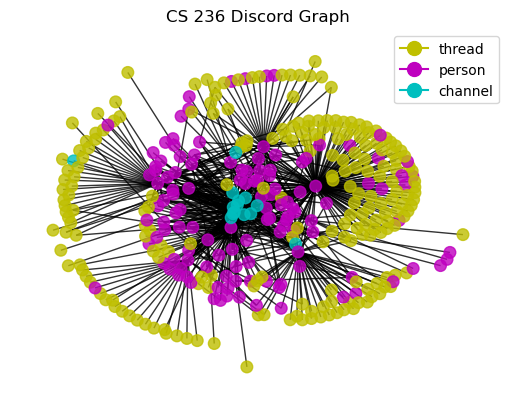

In [20]:
graph_handler = create_graph(nodes_data, edges_data, show_graph=True)

In [21]:
# messages = [message for message in list(edges_data['content']) if isinstance(message, str)]
# messages = [clean_message(message) for message in messages]
# tagged_data = [TaggedDocument(words=message, tags=[str(i)]) for i, message in enumerate(messages)]
# text_embedding_model = Doc2Vec(tagged_data, vector_size=100, window=5, workers=4, epochs=100)

In [22]:
# vectorize_message(model, edges_data.iloc[0, -1])

In [23]:
# vectorize_message(model, edges_data.iloc[0, -1])

In [26]:
spacy.cli.download('en_core_web_md')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [27]:
nlp = spacy.load('en_core_web_md') 

### Who was the most influential TA?

In [29]:
who_interacted_with_whom_handler = who_interacted_with_whom(graph_handler)

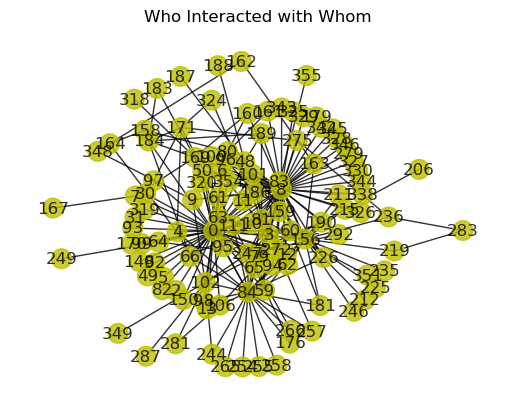

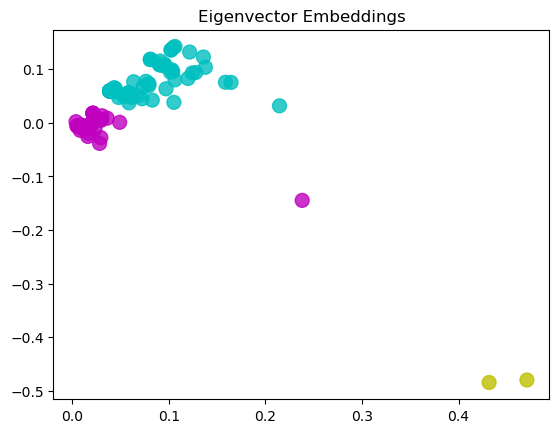

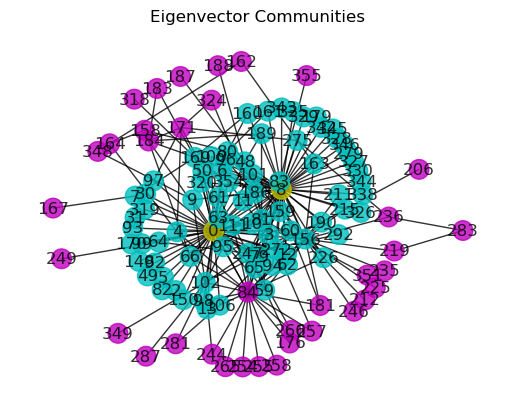

In [30]:
who_interacted_with_whom_handler.showGraph(title='Who Interacted with Whom', with_labels=True)
show_eigenvector_communities(who_interacted_with_whom_handler)

In [31]:
eigenvector_centrality(who_interacted_with_whom_handler, node_filter_val='TA')

0, TA: 0.47082382304039333
156, TA: 0.21459829335011235
169, TA: 0.11983996855087929
179, TA: 0.03871163310235631
171, TA: 0.02830611678100858
318, TA: 0.010747637868253362
164, TA: 0.008929827495846279


The TA with node type 0 is the most influential TA (I'm guessing this is Walter).  The top 3 are the following, in decreasing order: 0, 156, 169.  The other TAs seem very uninfluential (centralities close to 0).

### What types of messages did TA 0 send?

In [170]:
ta_0_messages = [message for message in edges_data[edges_data['source'] == 0]['content'] if isinstance(message, str)]
ta_0_messages_embeddings = np.array([vectorize_message(nlp, message) for message in ta_0_messages])
assert len(ta_0_messages) == len(ta_0_messages_embeddings)
ta_0_messages_embeddings.shape

(158, 300)

In [183]:
foo = [clean_message(nlp, message) for message in ta_0_messages]

'yes < 1148663286267641906 > specific hour ta plan work'

In [184]:
foo

['project submission question',
 'feel well 11:30',
 'nope',
 'ta today',
 'yes < 1148663286267641906 > specific hour ta plan work',
 'think fix affect grade reach problem',
 'grade merge tomorrow morning grade end day send dm netid github username',
 'zoom issue copy paste time time try manually type',
 'cool assume people take exam account later',
 'dictionary',
 '< > b a->b ^ b >',
 'require error state state question',
 '100',
 'check < 1146860399384338483 > channel',
 'yes final current plan weight second half content',
 'sand',
 'mean like ` ` ` 1 v b v c v d v e v f v g 2 b v c v d v e v f v g ` ` `',
 'unfortunately submit tommorow subject standard late penalty',
 'shoot dm figure auto grader pull date recent submission calculate grade',
 'pin int < 1148662249871908874 > channel',
 'record guarantee quality recording',
 'yeah get fix 😅',
 'additionally find site good https://madeby < person>.com fsm/',
 'yes 1 pm section https://discord.com/channels/1049410982167974018/11486622

In [171]:
pca = PCA(n_components=2)
ta_0_messages_embeddings_compressed = pca.fit_transform(ta_0_messages_embeddings)
print(ta_0_messages_embeddings_compressed.shape)
print(sum(pca.explained_variance_ratio_))

(158, 2)
0.2752789780497551


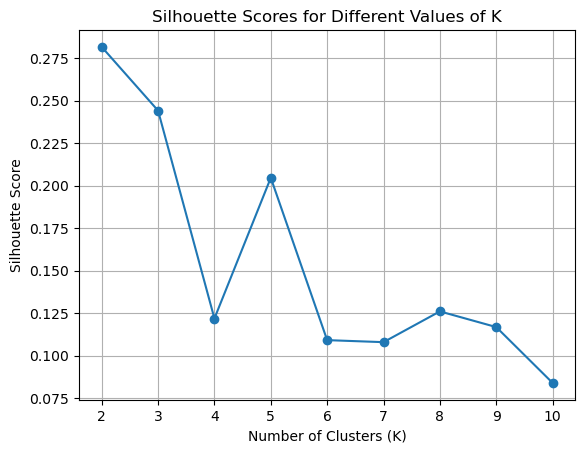

In [172]:
k = find_optimal_k(ta_0_messages_embeddings, show_plot=True)

It looks like a k of 2 is the best.

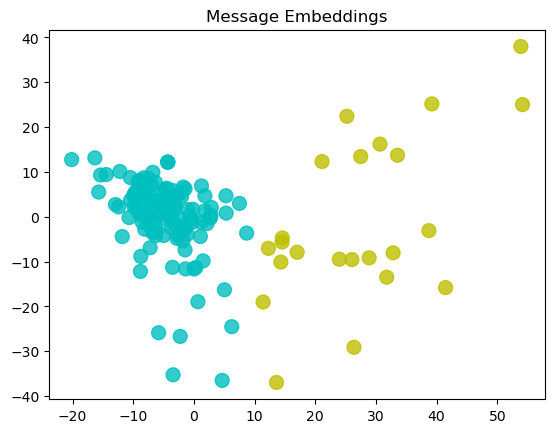

In [179]:
show_message_embeddings_communities(ta_0_messages_embeddings_compressed, n_clusters=k)

In [180]:
ta_0_messages_by_cluster = group_messages_by_clusters(ta_0_messages_embeddings, ta_0_messages, k)

4


In [175]:
ta_0_messages_by_cluster[0]

['Yes, see the <#1148663286267641906> for specific hours the TAs plan on working',
 'A <-> B\nIs the same as\n(A->B) ^ (B -> A)',
 'This, 100%',
 'Check the <#1146860399384338483>  channel',
 'Do you mean like this:\n```\n1. a v b v c v d v e v f v g\n2. not a\ntherefore: b v c v d v e v f v g\n```\n?',
 'it is also pinned int the <#1148662249871908874> channel',
 'should be at the top of the <#1148662249871908874> channel',
 'say our graph has 2 edges with weights\na->b: 5\nb->a: 4\n\nthe graph would be\n\nV = {a, b}\nE = {(a,b), (b,a)}\nw = {((a,b), 5), ((b,a), 4)}',
 'Your program will output an error message \n\nDetails on what the message looks like are on LS ->  Content -> Projects -> Project 1',
 '2 options:\n1\n```\nUse your diagram to encode the ID FSA to exclude RULES, FACTS, QUERIES, and SCHEMES as IDs\n```\n2\n```\nAdd a condition in somewhere where if the ID FSA and the FACTS, SCHEMES, RULES, or QUERIES FSA both announce that they accept preference the keyword FSA\n```',
 

^ These look like technical messages ^

In [176]:
ta_0_messages_by_cluster[1]

['Project Submission Question',
 "I'm feeling better so I'll be in at around 11:30",
 'Nope',
 'Will there be any TAs today?',
 'I think I fixed all affected grades, reach out if there was a problem with yours',
 'I will do a grade merge tomorrow morning, if your grade is not in by end of day send me a DM with your netid and GitHub username',
 'Zoom has issues with copy and paste from time to time, try manually typing it in',
 'Cool, I assume people who had already taken the exam will have that accounted for later?',
 'Up to you, I used a dictionary',
 'You will not be required to show the error state unless otherwise stated in the question',
 'Yes there will be a final\n\nCurrent plan for it is to be weighted towards the second half of the content',
 'The sand',
 'Unfortunately no, if you submit it tommorow it would be subject to the standard late penalty',
 'Shoot me a dm and we can get it figured out. The auto grader pulls the date from your most recent submission to calculate what 

^ These look like business and general instruction/clarification messages ^

In [177]:
print(len(ta_0_messages_by_cluster[0]), len(ta_0_messages_by_cluster[1]))

25 133


Since the second cluster is (by far) the largest and seems to contain messages around general instruction, perhaps more time could be spent improving project/assignment specs.

### What types of messages did students send?

In [143]:
student_nodes = set()

for _, row in nodes_data[['node', 'value']].iterrows():
    node_id, node_value = row['node'], row['value']
    if node_value == 'Student':
        student_nodes.add(node_id)

303

In [147]:
student_messages = [message for message in edges_data[edges_data['source'].isin(student_nodes)]['content'] if isinstance(message, str)]
student_messages_embeddings = np.array([vectorize_message(nlp, message) for message in student_messages])
assert len(student_messages) == len(student_messages_embeddings)
student_messages_embeddings.shape

(1148, 300)

In [148]:
pca = PCA(n_components=2)
student_messages_embeddings_compressed = pca.fit_transform(student_messages_embeddings)
print(student_messages_embeddings_compressed.shape)
print(sum(pca.explained_variance_ratio_))

(1148, 2)
0.23214516043663025


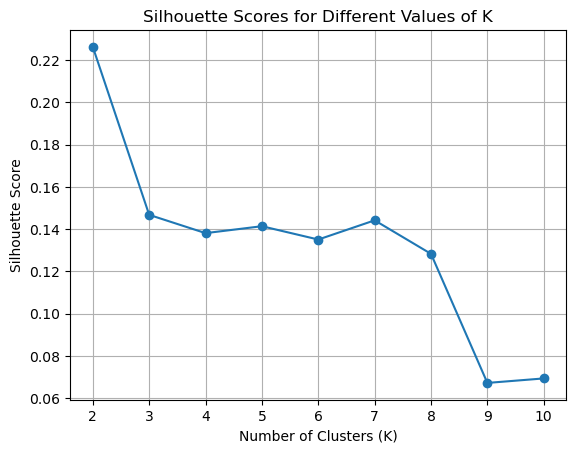

In [149]:
k = find_optimal_k(student_messages_embeddings, show_plot=True)

It looks like a k of 2 is the best.

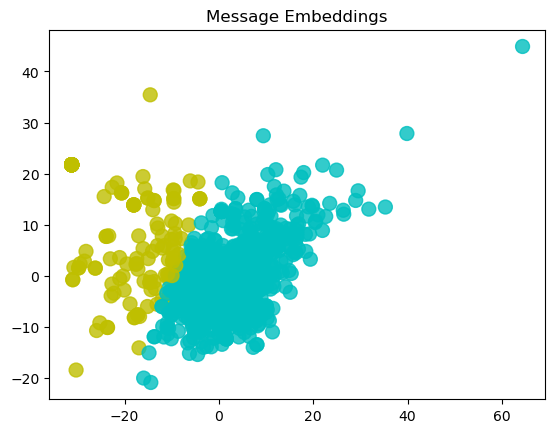

In [151]:
show_message_embeddings_communities(student_messages_embeddings_compressed, n_clusters=k)

In [152]:
student_messages_by_cluster = group_messages_by_clusters(student_messages_embeddings, student_messages, k)

In [153]:
student_messages_by_cluster[0]

["What is the best way to handle tokens of variable length (IDs, strings & comments)? It's easy to truncate fixed-length tokens from the file string after detection. My current plan is to add an extra output to my FSAs saying how many characters are included",
 'when you say output, do you mean an additional return object? cause you can also just make it an fsa class variable and add a getter function',
 "That's not an issue with your code, something is up on the github end",
 'I don\'t know if you ever got this fixed, but I think I fixed it by adding a + "\\n" to the end of my final output string. If you go in and look at the provided answers you\'ll see that there\'s an infernal extra space below every one.',
 "If a function has elements in its domain that are unmapped it would still be a function (assuming no inputs lead to 2+ outputs). I think that makes it a partial function. Injective doesn't have anything to do with all the domain elements being mapped so it is still injective. 

In [154]:
student_messages_by_cluster[1]

['I hope so! That’s how I’ve done everything.',
 'Just got it, thanks!',
 "Will there still be TA's available Mon-Wed this week?",
 "I had that happen to me too. Basically it's just a weird way of saying that you need to make sure to print out your Domain.",
 'I figured it that it is actually a problem with my rules I think thanks',
 'Is there a TA email?',
 'Thanks!',
 'Where can I find TA hours?',
 '\\n',
 'Did you get it checked off with a TA as well as just submitting it?',
 'Put what you want the name of it to be in the " "',
 'I did that and then it says all my autograders are failing',
 "Yeah that's correct",
 'Are there going to be TA hours tomorrow morning?',
 "That's fine. It's what I would do",
 'Do we still have ta today?',
 "Have you checked the actual website? For me, I don't exactly know what to say because it's hard to tell if anything's happened (I don't exactly understand what's happening in the picture, but a TA probably would) unless you tell me if it's not on the a

It looks like the first cluster primarily contains questions (with a few exceptions), while the second cluster primarily contains responses/statements (with a few exceptions).

### What types of messages did students send, broken down by project?

#### Project 1

In [166]:
project1_node_id = nodes_data[nodes_data['value'] == 'project-1']['node'].iloc[0]
project1_node_id

29

In [ ]:
student_messages = [message for message in edges_data[(edges_data['source'].isin(student_nodes)) & (edges_data['target'] == project1_node_id)]['content'] if isinstance(message, str)]
student_messages_embeddings = np.array([vectorize_message(nlp, message) for message in student_messages])
assert len(student_messages) == len(student_messages_embeddings)
student_messages_embeddings.shape

### Who were the most influential students?

In [20]:
who_interacted_with_whom_just_students_handler = who_interacted_with_whom_just_students(graph_handler)

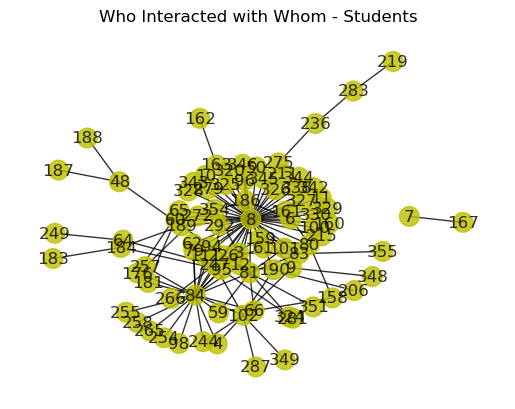

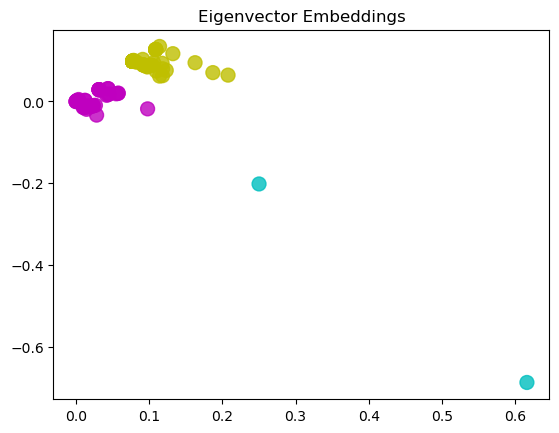

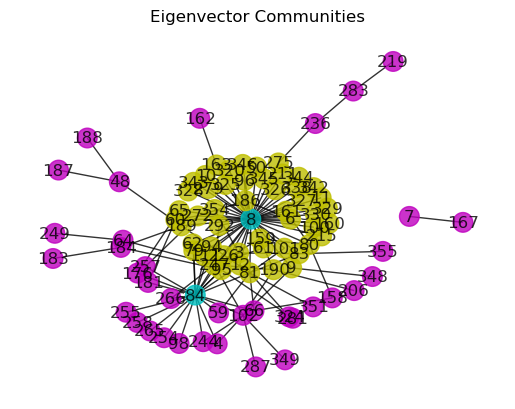

In [21]:
who_interacted_with_whom_just_students_handler.showGraph(title='Who Interacted with Whom - Students', with_labels=True)
show_eigenvector_communities(who_interacted_with_whom_just_students_handler)

In [22]:
eigenvector_centrality(who_interacted_with_whom_just_students_handler)

8, Student: 0.6162110052956096
84, Student: 0.25012466112542325
247, Student: 0.20776624345641997
81, Student: 0.18699489729011434
3, Student: 0.1627067501058233
12, Student: 0.13231872167290298
83, Student: 0.12328312156129852
159, Student: 0.11835997263937638
80, Student: 0.11823214337723437
190, Student: 0.11765191598085466
186, Student: 0.1142258769579439
95, Student: 0.11416230266965201
272, Student: 0.10957382012603264
62, Student: 0.10882821751708252
79, Student: 0.10882821751708252
94, Student: 0.10882821751708252
111, Student: 0.10882821751708252
226, Student: 0.10882821751708252
189, Student: 0.10616061517943826
61, Student: 0.1035075037069629
292, Student: 0.1035075037069629
101, Student: 0.10089820535142444
354, Student: 0.0978471490733513
102, Student: 0.09781700399531167
60, Student: 0.0966447360451028
160, Student: 0.0922601701280175
161, Student: 0.0922601701280175
6, Student: 0.09175689913117001
96, Student: 0.09175689913117001
9, Student: 0.09113364076005714
65, Stude

Student 8, by far, seemed to be the most influential.  This also makes sense based on what we saw from the projections when looking at the most influential TAs.  The top five, in decreasing order, are the following: 8, 94, 247, 81, 3.

### What types of messages did the most influential students send?

### Based on the previous question, which student(s) seemed to ask the most questions (i.e needed the most help)?

### Similar to the previous question, whish student(s) seemed to answer the most questions (i.e. helped the most)?